<a href="https://colab.research.google.com/github/nhyha/goorm/blob/main/groom_1%EC%B0%A8_study_%EB%B9%88%EB%8F%84%EB%B6%84%EC%84%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [65]:
## Imorting Library
import numpy as np
import pandas as pd
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')  # 토큰화를 위해 필요한 자원 다운로드
import matplotlib.pyplot as plt
from collections import Counter
import matplotlib.font_manager as fm
!apt-get update -qq # 폰트 다운1
!apt-get install fonts-nanum* -qq # 폰트 다운2
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [66]:
## Importing Files
url = 'https://raw.githubusercontent.com/nhyha/goorm/main/'

# 두 파일을 각각 DataFrame으로 불러옴
df1 = pd.read_csv(url+'data/Intel-neural-chat-7b-v3-1_LLMEssays_v1.csv')
df2 = pd.read_csv(url+'data/train_essays.csv')

# 두 DataFrame을 train.csv 하나로 결합
train = pd.concat([df1, df2], ignore_index=True)
train.rename(columns = {'essay_id': 'id','label' : 'generated','prompt': 'prompt_id'}, inplace=True)
train['prompt_id'] = pd.factorize(train['prompt_id'])[0]
train = train[['id', 'prompt_id', 'text', 'generated']]
train.drop('id', axis=1, inplace=True) # id 부분 드랍
train

,prompt_id,text,generated
0,0,"\n\n It might seem like a far-fetched idea, th...",1
1,0,"\n\nCar-free cities, as the term itself sugges...",1
2,0,\n\n\n\nCar-free cities: A step towards livabl...,1
3,0,\n\n\n\nCar-free cities may seem like a utopia...,1
4,0,"\n\nAn overview of car-free cities: Pros, cons...",1
...,...,...,...
2873,4,There has been a fuss about the Elector Colleg...,0
2874,3,Limiting car usage has many advantages. Such a...,0
2875,3,There's a new trend that has been developing f...,0
2876,3,As we all know cars are a big part of our soci...,0


In [67]:
## 합쳐진 파일 전처리(promt_id 부분 수정, text에서 결측치 행 드랍)
train['prompt_id'].replace({3: 0, 4: 1}, inplace=True) # prompt_id에서 3을 0으로, 4를 1로 변경
train.dropna(inplace=True) # 결측치 부분 드랍
train

,prompt_id,text,generated
0,0,"\n\n It might seem like a far-fetched idea, th...",1
1,0,"\n\nCar-free cities, as the term itself sugges...",1
2,0,\n\n\n\nCar-free cities: A step towards livabl...,1
3,0,\n\n\n\nCar-free cities may seem like a utopia...,1
4,0,"\n\nAn overview of car-free cities: Pros, cons...",1
...,...,...,...
2873,1,There has been a fuss about the Elector Colleg...,0
2874,0,Limiting car usage has many advantages. Such a...,0
2875,0,There's a new trend that has been developing f...,0
2876,0,As we all know cars are a big part of our soci...,0


In [68]:
## 빈도 분석
# 사람들이 쓰는 단어 뽑아내기
text_generated_0 = train[train['generated'] == 0]['text']# generated 열이 0인 경우의 text 추출
tokenized_text_generated_0 = text_generated_0.apply(word_tokenize)# text_generated_0을 토큰화

# AI가 많이 쓰는 단어 뽑아내기
text_generated_1 = train[train['generated'] == 1]['text']  # generated 열이 1인 경우의 text 추출
tokenized_text_generated_1 = text_generated_1.apply(word_tokenize)# text_generated_1을 토큰화

# # prompt가 0인 경우에 많이 쓰는 단어 뽑아내기
# text_prompt_0 = train[train['prompt_id'] == 0]['text']  # prompt 열이 0인 경우의 text 추출
# tokenized_text_prompt_0 = text_prompt_0.apply(word_tokenize)# text_prompt_0을 토큰화

# # prompt가 1인 경우에 많이 쓰는 단어 뽑아내기
# text_prompt_1 = train[train['prompt_id'] == 1]['text']  # prompt 열이 0인 경우의 text 추출
# tokenized_text_prompt_1 = text_prompt_1.apply(word_tokenize)# text_prompt_0을 토큰화

# print(tokenized_text_prompt_0)
# print(tokenized_text_prompt_1)

print(tokenized_text_generated_0)
print(tokenized_text_generated_1)

1500    [Cars, ., Cars, have, been, around, since, the...
1501    [Transportation, is, a, large, necessity, in, ...
1502    [``, America, 's, love, affair, with, it, 's, ...
1503    [How, often, do, you, ride, in, a, car, ?, Do,...
1504    [Cars, are, a, wonderful, thing, ., They, are,...
                              ...                        
2873    [There, has, been, a, fuss, about, the, Electo...
2874    [Limiting, car, usage, has, many, advantages, ...
2875    [There, 's, a, new, trend, that, has, been, de...
2876    [As, we, all, know, cars, are, a, big, part, o...
2877    [Cars, have, been, around, since, the, 1800, '...
Name: text, Length: 1375, dtype: object
0       [It, might, seem, like, a, far-fetched, idea, ...
1       [Car-free, cities, ,, as, the, term, itself, s...
2       [Car-free, cities, :, A, step, towards, livabl...
3       [Car-free, cities, may, seem, like, a, utopian...
4       [An, overview, of, car-free, cities, :, Pros, ...
                              ..

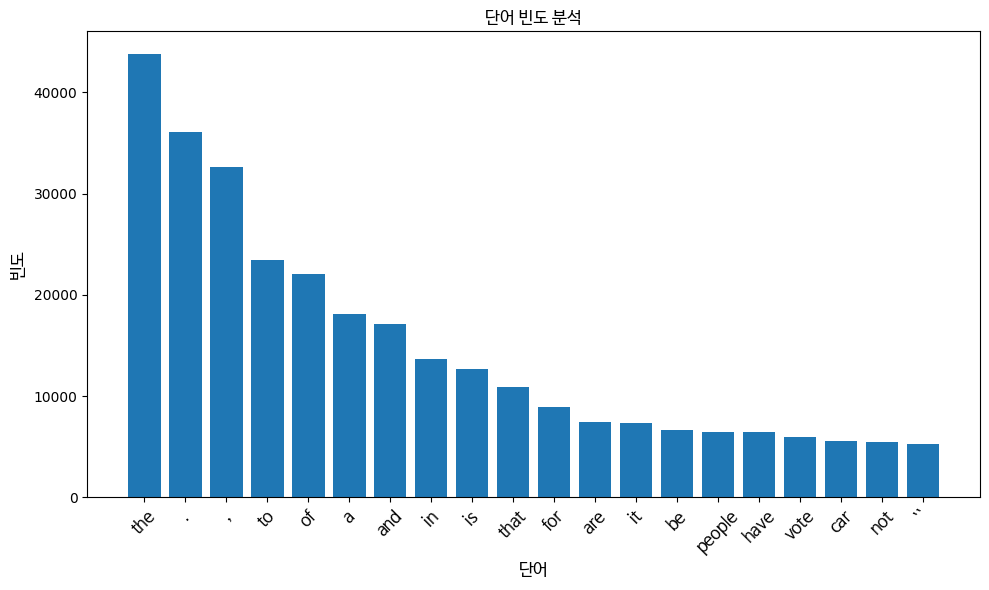

In [69]:
## 사람들이 많이 쓰는 단어 빈도 확인
# 토큰화된 단어들의 빈도 계산
human_all_words = [word for sublist in tokenized_text_generated_0 for word in sublist]
human_word_freq = Counter(human_all_words)

# 가장 빈도가 높은 상위 20개 단어 추출
top_words = human_word_freq.most_common(20)
top_words_df = pd.DataFrame(top_words, columns=['Word', 'Frequency'])

# 한글 폰트 설정
font_path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'   # 사용하고자 하는 한글 폰트 경로
font_prop = fm.FontProperties(fname=font_path, size=12)

# 그래프로 시각화
plt.figure(figsize=(10, 6))
plt.bar(top_words_df['Word'], top_words_df['Frequency'])
plt.title('단어 빈도 분석', fontproperties=font_prop)  # 한글 제목 적용
plt.xlabel('단어', fontproperties=font_prop)  # 한글 x축 라벨 적용
plt.ylabel('빈도', fontproperties=font_prop)  # 한글 y축 라벨 적용
plt.xticks(rotation=45, fontproperties=font_prop)  # x축 라벨 회전 및 한글 폰트 적용
plt.tight_layout()
plt.show()

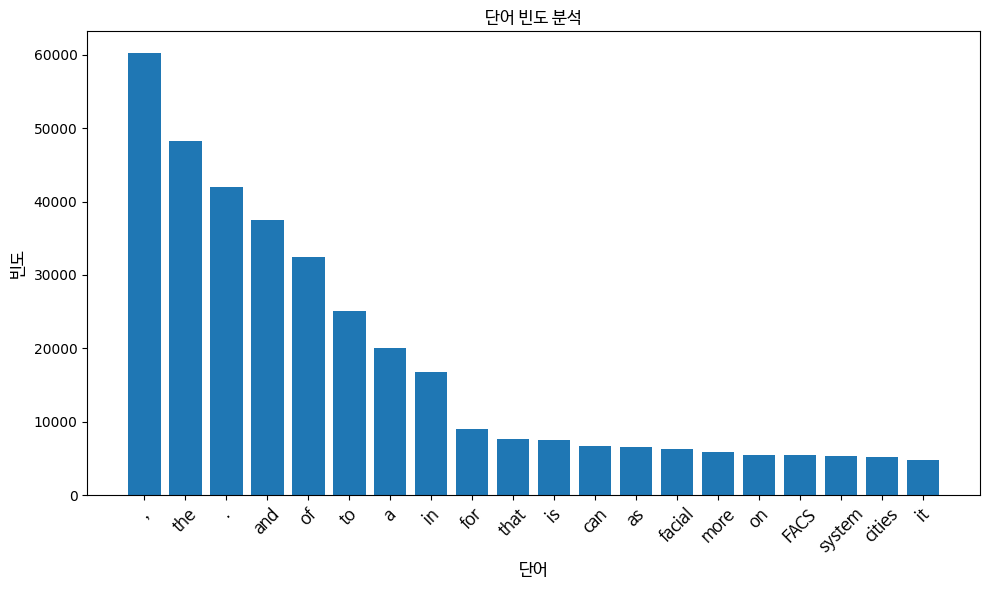

In [70]:
## AI가 많이 쓰는 단어 빈도 확인
# 토큰화된 단어들의 빈도 계산
AI_all_words = [word for sublist in tokenized_text_generated_1 for word in sublist]
AI_word_freq = Counter(AI_all_words)

# 가장 빈도가 높은 상위 20개 단어 추출
top_words = AI_word_freq.most_common(20)
top_words_df = pd.DataFrame(top_words, columns=['Word', 'Frequency'])

# 그래프로 시각화
plt.figure(figsize=(10, 6))
plt.bar(top_words_df['Word'], top_words_df['Frequency'])
plt.title('단어 빈도 분석', fontproperties=font_prop)  # 한글 제목 적용
plt.xlabel('단어', fontproperties=font_prop)  # 한글 x축 라벨 적용
plt.ylabel('빈도', fontproperties=font_prop)  # 한글 y축 라벨 적용
plt.xticks(rotation=45, fontproperties=font_prop)  # x축 라벨 회전 및 한글 폰트 적용
plt.tight_layout()
plt.show()

In [71]:
## TF-IDF 분석
# TF-IDF : 주로 문서의 유사도를 구하는 작업, 검색 시스템에서 검색 결과의 중요도를 정하는 작업,
#          문서 내에서 특정 단어의 중요도를 구하는 작업에 사용됨, DTM 내의 각 단어들마다 중요한 정도를 가중치로 주는 방법입니다.
# TF-IDF 값 특징 : TF-IDF는 모든 문서에서 자주 등장하는 단어는 중요도가 낮다고 판단하며,
#                   특정 문서에서만 자주 등장하는 단어는 중요도가 높다고 판단합니다.
#                   TF-IDF 값이 낮으면 중요도가 낮은 것이며, TF-IDF 값이 크면 중요도가 큰 것입니다.
#                   즉, the나 a와 같이 불용어의 경우에는 모든 문서에 자주 등장하기 마련이기 때문에
#                   자연스럽게 불용어의 TF-IDF의 값은 다른 단어의 TF-IDF에 비해서 낮아지게 됩니다.

# DTM : ex) 형식|단어 the and of is that it ...
#           사람      10   20  5  2  1    0
#            AI         5   10  3  6  3    3

# tf(d,t) : 특정 문서 d에서의 특정 단어 t의 등장 횟수.
# df(t) : 특정 단어 t가 등장한 문서의 수.
# idf(t) : df(t)에 반비례하는 수.
# TF-IDF : tf와 idf의 곱을 의


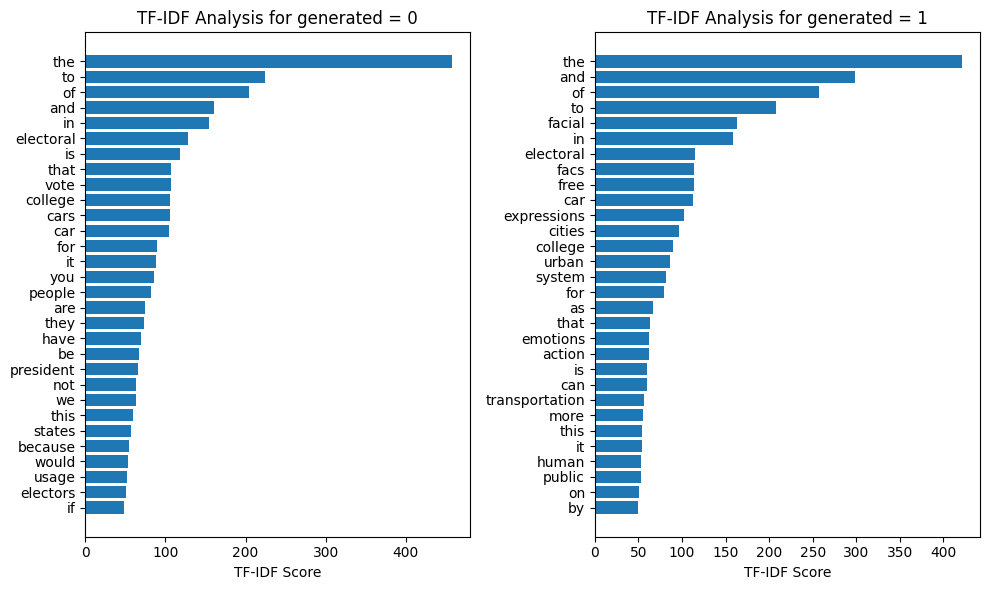

In [90]:
# text 데이터를 다시 합치기
train['text'] = train['text'].apply(lambda x: str(x)) # 결측치가 있을 경우를 대비하여 문자열로 변환
text_generated_0 = train[train['generated'] == 0]['text'].tolist()  # generated 열이 0인 경우의 text 추출
text_generated_1 = train[train['generated'] == 1]['text'].tolist()  # generated 열이 1인 경우의 text 추출
text_all = text_generated_0 + text_generated_1  # 모든 텍스트 합치기

# TfidfVectorizer를 사용하여 TF-IDF 계산
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(text_all) # fit은 토큰화를 진행하고 IDF를 진행,
                                       # transform은 각 문서의 TF-IDF를 계산하여 문서-단어 행렬 생성,
                                       # X라는 희소행렬 생성
feature_names = vectorizer.get_feature_names_out() # 생성된 단어들의 목록을 feature_names변수에 저장


# 각 클래스(generated = 0, 1)에 대한 TF-IDF 값을 구하기 위해 데이터를 분리
tfidf_generated_0 = X[:len(text_generated_0)] # 사람 TF-IDF 정보
tfidf_generated_1 = X[len(text_generated_0):] # AI TF-IDF 정보

# TF-IDF 값을 데이터프레임으로 변환
df_tfidf_generated_0 = pd.DataFrame(tfidf_generated_0.toarray(), columns=feature_names)
df_tfidf_generated_1 = pd.DataFrame(tfidf_generated_1.toarray(), columns=feature_names)

# 시각화
top_words = 30
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.barh(df_tfidf_generated_0.sum().sort_values(ascending=False).head(top_words).index[::-1], df_tfidf_generated_0.sum().sort_values(ascending=False).head(top_words)[::-1])
plt.title('TF-IDF Analysis for generated = 0')
plt.xlabel('TF-IDF Score')

plt.subplot(1, 2, 2)
plt.barh(df_tfidf_generated_1.sum().sort_values(ascending=False).head(top_words).index[::-1], df_tfidf_generated_1.sum().sort_values(ascending=False).head(top_words)[::-1])
plt.title('TF-IDF Analysis for generated = 1')
plt.xlabel('TF-IDF Score')

plt.tight_layout()
plt.show()


In [91]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [92]:
cd /content/drive/MyDrive/groom_kaggle_빈도분석_HSJ

/content/drive/MyDrive/groom_kaggle_빈도분석_HSJ


In [93]:
! git clone https://github.com/nhyha/goorm.git

Cloning into 'goorm'...
remote: Enumerating objects: 138, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 138 (delta 22), reused 11 (delta 11), pack-reused 102
Receiving objects: 100% (138/138), 5.72 MiB | 4.55 MiB/s, done.
Resolving deltas: 100% (45/45), done.
